#1.인트로

##1.1 문제 유형 및 데이터 정리

https://dacon.io/competitions/open/235538/overview/description

주어진 데이터를 바탕으로 선수 이적료를 예측 해보세요!

1. FIFA_train.csv / FIFA_test.csv\
 id : 선수 고유의 아이디\
 name : 이름\
 age : 나이\
 continent : 선수들의 국적이 포함되어 있는 대륙입니다\
 contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다\
 position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등\
 prefer_foot : 선수가 선호하는 발입니다. ex) 오른발\
 reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수\
 stat_overall : 선수의 현재 능력치 입니다.\
 stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.\
 stat_skill_moves : 선수의 개인기 능력치 입니다.\
 value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다\


2. submission.csv (제출 파일 형식)\
id : 선수 고유의 아이디\
value : 예측된 선수 이적 시장 가격을 기입 

##1.2 패키지 로드

In [91]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


##1.3 데이터 로드

###1.3.1 파일 로드

In [92]:
df_train = pd.read_csv('FIFA_train.csv')
df_test = pd.read_csv('FIFA_test.csv')
df_submission = pd.read_csv('submission.csv')

###1.3.2 구글 드라이브 로드

#2.전처리

삭제, 치환, 결측치 추가, 이상치 제거, 표준화, 정규화

##2.1 데이터 확인

In [93]:
df_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [94]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [95]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3828 non-null   int64  
 1   name              3828 non-null   object 
 2   age               3828 non-null   int64  
 3   continent         3828 non-null   object 
 4   contract_until    3828 non-null   object 
 5   position          3828 non-null   object 
 6   prefer_foot       3828 non-null   object 
 7   reputation        3828 non-null   float64
 8   stat_overall      3828 non-null   int64  
 9   stat_potential    3828 non-null   int64  
 10  stat_skill_moves  3828 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 329.1+ KB


In [96]:
df_train.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [97]:
df_train.corr().value

id                 -0.544280
age                 0.087319
reputation          0.665982
stat_overall        0.658444
stat_potential      0.611907
stat_skill_moves    0.298500
value               1.000000
Name: value, dtype: float64

##2.2 데이터 시각화

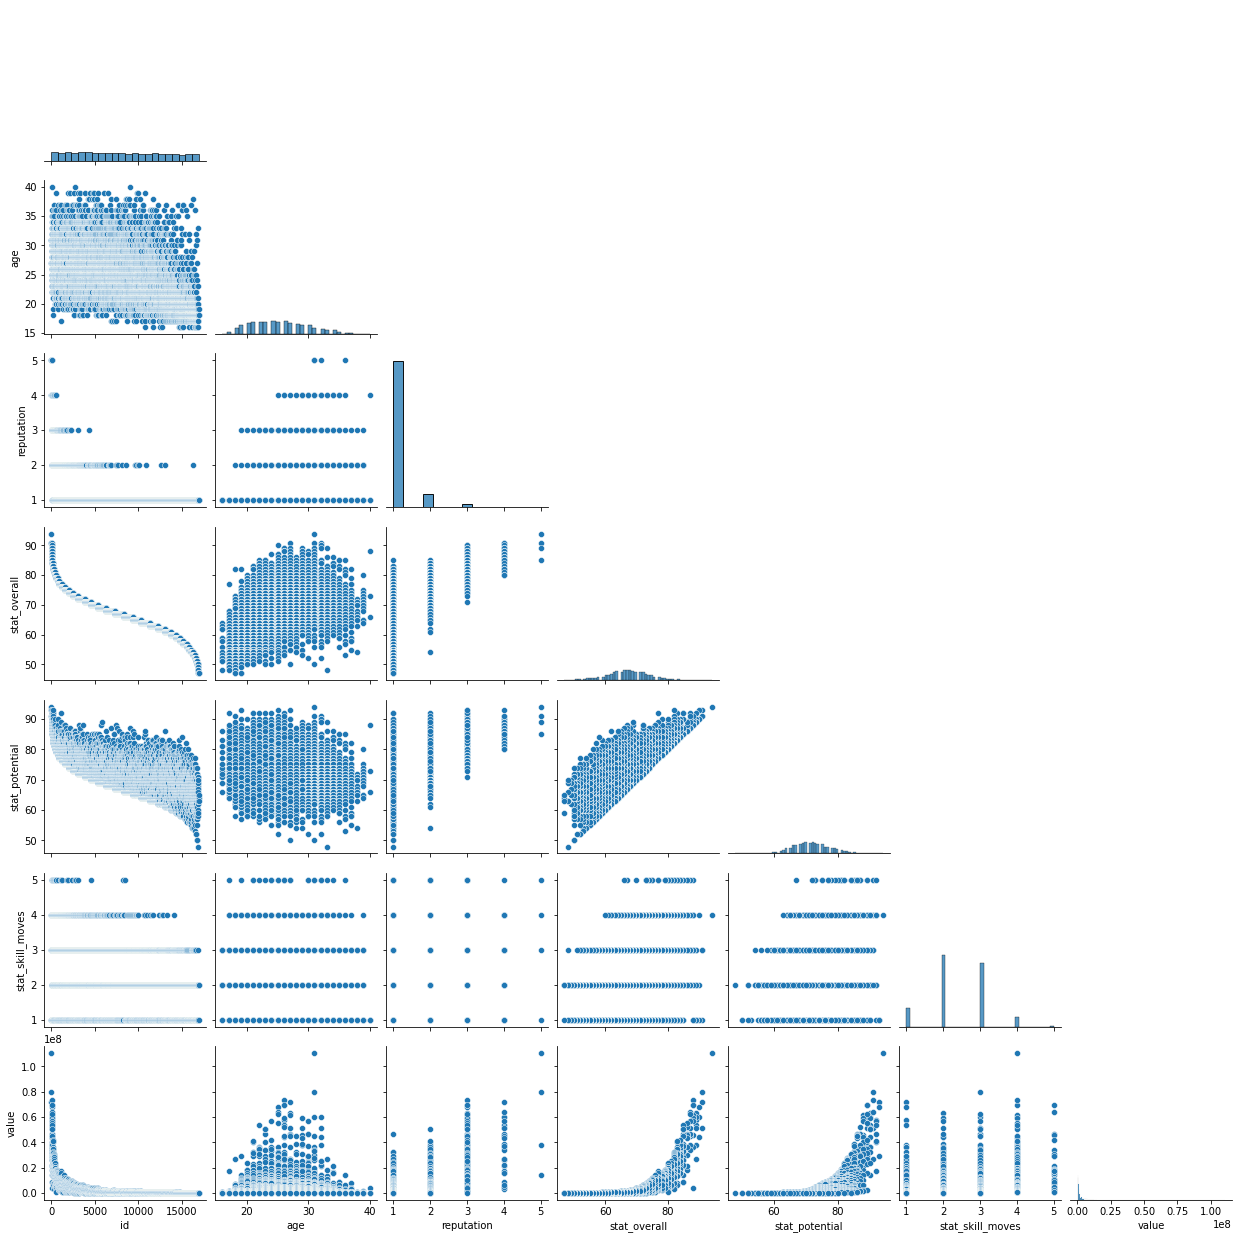

In [98]:
sns.pairplot(df_train, corner=True)

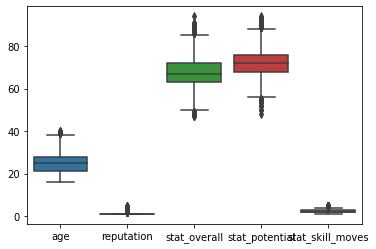

In [99]:
df1 = df_train.drop(["id","value"], axis =1)
sns.boxplot(data = df1)

##2.3 인코딩

In [100]:
df_train = pd.concat([df_train, pd.get_dummies(df_train["continent"])], axis =1)
df_train = pd.concat([df_train, pd.get_dummies(df_train["position"])], axis =1)
df_train = pd.concat([df_train, pd.get_dummies(df_train["prefer_foot"])], axis =1)

df_test = pd.concat([df_test, pd.get_dummies(df_test["continent"])], axis =1)
df_test = pd.concat([df_test, pd.get_dummies(df_test["position"])], axis =1)
df_test = pd.concat([df_test, pd.get_dummies(df_test["prefer_foot"])], axis =1)

##2.4 이상치 제거

##2.5 컬럼 제거

In [101]:
df_train.drop(["name","continent","position","prefer_foot","contract_until"],axis=1,inplace=True)

df_test.drop(["name","continent","position","prefer_foot","contract_until"],axis=1,inplace=True)

In [102]:
df_train.columns

Index(['id', 'age', 'reputation', 'stat_overall', 'stat_potential',
       'stat_skill_moves', 'value', 'africa', 'asia', 'europe', 'oceania',
       'south america', 'DF', 'GK', 'MF', 'ST', 'left', 'right'],
      dtype='object')

In [103]:
df_train = df_train[["id",'age', 'reputation', 'stat_overall', 'stat_potential',
       'stat_skill_moves', 'africa', 'asia', 'europe', 'oceania',
       'south america', 'DF', 'GK', 'MF', 'ST', 'left', 'right', 'value']]

#3.학습 & 예측

In [104]:
x, y = df_train.iloc[:, 2:6], df_train.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.25, random_state= 1)

ranfo_pipline = Pipeline([("scaler",StandardScaler()),("model",RandomForestRegressor(n_jobs=-1, random_state=1))])
ranfo_pipline.fit(x_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=1))])

In [105]:
rcs_x = df_test.iloc[:,2:6]

In [106]:
pred = ranfo_pipline.predict(rcs_x)

In [107]:
df_submission.value = pred
df_submission

,id,value
0,1,9.870000e+07
1,2,7.791000e+07
2,4,6.399750e+07
3,5,6.390750e+07
4,6,6.390750e+07
...,...,...
3823,16924,5.907778e+04
3824,16929,5.120000e+04
3825,16932,5.345611e+04
3826,16937,4.320000e+04


#4.성능 지표 확인

In [108]:
pred_ranfo = ranfo_pipline.predict(x_test)
rmse = mean_squared_error(y_test, pred_ranfo)**2
print(rmse)

1.2516185132372814e+24


In [109]:
print("학습률 : ",ranfo_pipline.score(x_train, y_train))
print("예측률 : ",ranfo_pipline.score(x_test, y_test))

학습률 :  0.9818387309106552
예측률 :  0.9651517625328759


#5.저장

##5.1 github에 저장

##5.2 파일로 저장

In [110]:
df_submission.to_csv('3번째 수정.csv', index=None)